# Clustering

Music helps players immerse theselves in video games by setting the mood for fighting an exciting battle, exploring a peaceful village, laughing at humour, or feeling heartache in sadness. 
If the tracks had features to describe their audio qualities, would clustering group the different tracks such that the clusters reflect the different moods in the game?

This notebook will analyse The Legend of Heroes: Trails of Cold Steel (ToCS) Original Sound Track by [Falcom Sound Team jdk](https://open.spotify.com/artist/5WFofzgRxpVNkpwg9XRSdg). Note that there are 4 games in the Trails of Cold Steel series, and this notebook will only examine the sound track for the first game. 

## Prepare notebook

In [79]:
# Import Drive helper and mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Suppress output of cell
%%capture

# Install and import spotipy to access Spotify API
!pip install spotipy
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Import configparser for loading configuration to call Spotify API
import configparser

# Import json to format JSON strings
#import json # print(json.dumps(jsonString, indent=2))

# Import pandas for dataframes
import pandas as pd 

# Import matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline 

# Import numpy to help with plots
import numpy as np

# Import scikit-learn for scaling and k-means clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [0]:
# Define main path
homePath = '/content/drive/My Drive/Colab Notebooks'

# Define path to the Spotify configuration file
configFilePath = f'{homePath}/bin/spotify_client_config.txt'

# Define path to save data
dataPath = f'{homePath}/Data/Spotify audio features'

### Functions

In [0]:
def initSpotifyClient(configFilePath):
  """
  Initialise Spotify client to use Spotify API.
  
  :param configFilePath: Path the Spotify config file
  :returns: Spotify client
  """
  # Load the Spotify client configuration file
  config = configparser.ConfigParser()
  config.read('/content/drive/My Drive/Colab Notebooks/bin/spotify_client_config.txt')

  print(f'Loaded config file with settings for: {config.sections()}')

  # Use configuration to set up Spotify client authorisation
  client_credentials_manager = \
  SpotifyClientCredentials(client_id=config['developer.spotify.com']['cid'], \
                           client_secret=config['developer.spotify.com']['secret'])

  # Initialise the Spotify client
  sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
  
  print('Authorised Spotify client has been initialised')
  
  return sp


def getAlbumTracks(sp, albumUrl):
  """
  Gets IDs and names of all tracks in the album, and returns them in a list.
  
  :param sp: Spotify client
  :param albumUrl: URL of album on Spotify
  :returns: List containing IDs and names of tracks in the album
  """
  
  # Get album information from Spotify
  album = sp.album(albumUrl)
  numTracks = album['total_tracks']
  albumName = album['name']
  
  print(f'Found {numTracks} in {albumName}')
  
  # Initialise empty list
  trackList = []
  
  print(f'Start extracting track IDs and names from {albumName}')

  # Iterate over all tracks
  for trackIdx in range(0, numTracks):
    # Record the track ID and name
    trackList.append([
        album['tracks']['items'][trackIdx]['id'],
        album['tracks']['items'][trackIdx]['name']
    ])

  print(f'Finished extracting track IDs and names from {albumName}')
    
  return trackList


def getTrackAudioFeatures(sp, trackList):
  """
  Gets audio features of all tracks in the list and returns them in a dataframe.
  
  :param sp: Spotify client
  :param trackList: List of IDs and names of tracks
  :returns: Dataframe of audio features for each track
  """
  # Count the number of tracks
  numTracks = len(trackList)
  
  # Initialise empty list
  featuresList = []
  
  print(f'Start getting audio features for {numTracks} tracks')
  
  # Iterate over all tracks
  for trackIdx in range(0, numTracks):
    # Get track ID and name from list
    trackID = trackList[trackIdx][0]
    trackName = trackList[trackIdx][1]
    
    # Get track audio features from Spotify
    trackFeatures = sp.audio_features(trackID)
    
    # Append audio features into list
    featuresList.append([
        trackID,
        trackName,
        trackFeatures[0]['acousticness'],
        trackFeatures[0]['danceability'],
        trackFeatures[0]['duration_ms'],
        trackFeatures[0]['energy'],
        trackFeatures[0]['instrumentalness'],
        trackFeatures[0]['key'],
        trackFeatures[0]['liveness'],
        trackFeatures[0]['loudness'],
        trackFeatures[0]['mode'],
        trackFeatures[0]['speechiness'],
        trackFeatures[0]['tempo'],
        trackFeatures[0]['time_signature'],
        trackFeatures[0]['valence']
    ])
  
  # Define output dataframe columns
  colNames = ['id', 'name', 'acousticness', 'danceability', 'duration_ms',\
             'energy', 'instrumentalness', 'key', 'liveness', 'loudness',\
             'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
  
  # Convert the list into a dataframe
  featuresDF = pd.DataFrame(featuresList, columns = colNames)
  
  print(f'Finished getting audio features for {numTracks} tracks')
  
  return featuresDF



def plotCorrMat(df, numCols):
  """
  Plots correlation matrix for input data.
  
  :param df: input dataframe
  :param numCols: number of columns in the dataframe
  :returns: correlation matrix
  """
  
  # Calculate correlation
  corr = df.corr()

  sns.set(style="white")

  # Generate a mask for the upper triangle
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  
  # Set square figure size
  length = 2*numCols

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(length, length))

  # Generate diverging colourmap
  cmap = sns.color_palette("RdBu_r", 10)

  # Generate heatmap with mask and resized colour bar
  hmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, cbar_kws={"shrink": .5});
  
  # Rotate the y-axis labels to be read horizontally
  plt.yticks(rotation = 0)
  
  # Show the heatmap before exiting the function
  plt.show(hmap)
  
  return corr

## Get audio features

Each track in the Spotify system has 13 audio features that can be accessed via an API. The table that follows summarise what each audio feature represents (Spotify). 

| Audio feature | Definition |
| :--- | :--- |
| acousticness | A number from 0 to 1 for classifying the track as acoustic. <br> A higher value means the track is more likely to be acoustic.
| danceability |  A number from 0 to 1 for recommending the track for dancing. <br> A higher value means the track has a stronger recommendation (higher suitability) for dancing.
| duration_ms | The length of the track measured in milliseconds.
| energy | A number from 0 to 1 that describes the perceived intensity and activity in the track. <br> A higher value means the track has more energy (e.g. fast, loud, noisy)
| instrumentalness | A number from 0 to 1 for classifying the track as having vocals or not. <br> A higher value means the track is more likely to have no vocals.
| key | An integer from -1 to 11 that represents the estimated average pitch class of the track. <br> The values 0 to 11 represent pitch class according to [pitch class notation](https://en.wikipedia.org/wiki/Pitch_class#Other_ways_to_label_pitch_classes). <br> The value -1 represents no pitch class.
| liveness | A number from 0 to 1 for classifying the track as having an audience present. <br> A higher value means it is more likely that the track contains the sounds of an audience.
| loudness | The average loudness of the track in decibels.
| mode | A value of 1 means the track is in a major key, whereas a value of 0 means a minor key.
| speechiness | A number from 0 to 1 for classifying the track as having spoken words. <br> A value under 0.33 suggests the track has no spoken words. <br> A value from 0.33 to 066 suggests a mix of music and speech. <br> A value above 0.66 suggests little to no music.
| tempo | The estimated average number of beats per minute.
| time_signature |  The estimated average number of beats in a bar.
| valence | A number from 0 to 1 that describes how positive the track sounds. <br> A higher value means the track sounds more positive.

In [83]:
# Initialise the Spotify client
sp = initSpotifyClient(configFilePath)

Loaded config file with settings for: ['developer.spotify.com']
Authorised Spotify client has been initialised


In [84]:
# Define the URLs of the albums of interest
albumUrlVol1 = 'https://open.spotify.com/album/0Bq2ouxMyyk7547IQA0W7Y'
albumUrlVol2 = 'https://open.spotify.com/album/2HjcJDx7Hrb28YHoCCS7qA'

# Put the URLs in a list
urlList = [albumUrlVol1, albumUrlVol2]

# Initialise master list
masterList = []

# For each album
for url in urlList:
  # Get track list for the album
  trackList = getAlbumTracks(sp, url)
  
  # Combine all track lists into one list
  masterList.extend(trackList)
  
# Get audio features for tracks in the master list
featuresDF = getTrackAudioFeatures(sp, masterList)

# Save data to CSV on Google drive
#featuresDF.to_csv(f'{dataPath}/tocs_ost_audio_features.csv', index=False)

# Show features summary
display(featuresDF.describe())

Found 45 in The Legend of Heroes: Sen No Kiseki Original Soundtrack Vol.1
Start extracting track IDs and names from The Legend of Heroes: Sen No Kiseki Original Soundtrack Vol.1
Finished extracting track IDs and names from The Legend of Heroes: Sen No Kiseki Original Soundtrack Vol.1
Found 42 in The Legend of Heroes: Sen No Kiseki Original Soundtrack Vol.2
Start extracting track IDs and names from The Legend of Heroes: Sen No Kiseki Original Soundtrack Vol.2
Finished extracting track IDs and names from The Legend of Heroes: Sen No Kiseki Original Soundtrack Vol.2
Start getting audio features for 87 tracks
Finished getting audio features for 87 tracks


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,0.384066,0.413929,169045.011494,0.551929,0.670231,5.482759,0.185759,-9.814103,0.517241,0.043754,113.773655,3.758621,0.378586
std,0.356530,0.150735,64246.045061,0.265775,0.324692,3.540011,0.107218,3.875962,0.502599,0.021984,33.566882,0.504987,0.239978
min,0.000001,0.074800,33027.000000,0.029200,0.000000,0.000000,0.048700,-22.627000,0.000000,0.025600,50.893000,1.000000,0.032500
25%,0.020650,0.295000,128746.500000,0.350000,0.568000,2.500000,0.108000,-12.060500,0.000000,0.030550,89.166500,4.000000,0.184000
50%,0.259000,0.436000,155093.000000,0.537000,0.817000,6.000000,0.143000,-9.619000,1.000000,0.034500,101.901000,4.000000,0.329000
75%,0.700500,0.502500,190727.000000,0.804000,0.904500,9.000000,0.256500,-6.958500,1.000000,0.050550,139.988000,4.000000,0.557000
max,0.981000,0.744000,373040.000000,0.990000,0.969000,11.000000,0.503000,-1.711000,1.000000,0.135000,195.160000,4.000000,0.947000


## Process audio features

### Select features to use

First, it would useful to select relevant audio features to differentiate the soundtracks. A significant purpose of video game music is to set the mood for the scene. Therefore, audio features that are relevant to describing the mood of the music should be used. The features considered relevant are energy, key, loudness, mode, tempo, time signature, and valence.

Some of the features may be strongly correlated. For example, a track with high energy is one that is fast, loud, and noisy. The speed of the track could be described using tempo, and the volume could be described using loudness. Hence, it would be a good idea to check the correlation of the selected features.

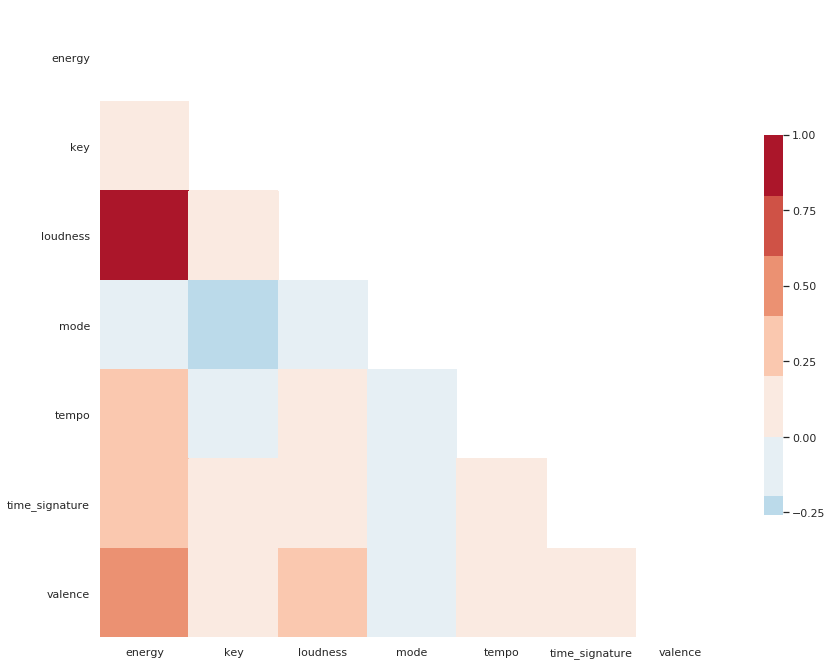

,energy,key,loudness,mode,tempo,time_signature,valence
energy,1.000000,0.120236,0.820130,-0.140149,0.371125,0.226272,0.427913
key,0.120236,1.000000,0.037797,-0.259615,-0.014144,0.059438,0.192420
loudness,0.820130,0.037797,1.000000,-0.136166,0.196183,0.098966,0.326408
mode,-0.140149,-0.259615,-0.136166,1.000000,-0.086033,-0.097947,-0.139085
tempo,0.371125,-0.014144,0.196183,-0.086033,1.000000,0.190514,0.170571
time_signature,0.226272,0.059438,0.098966,-0.097947,0.190514,1.000000,0.117100
valence,0.427913,0.192420,0.326408,-0.139085,0.170571,0.117100,1.000000


In [85]:
# Choose relevant features to keep
featuresSubset_1 = featuresDF[['energy', 'key', 'loudness', 'mode', 'tempo', 'time_signature', 'valence']]

# Plot correlation to check for highly correlated features
corr = plotCorrMat(featuresSubset_1, len(featuresSubset_1.columns))

# Show exact values
display(corr)

There is very high correlation (0.82) between energy and loudness, which is not surprising because energy is dependent on the volume of the music.
The values for loudness have a slightly different magnitude compared to the other features, so loudness is removed.
Energy is also dependent on the speed of the music, but the correlation between energy and tempo is low (0.37), so both features are kept.

There is moderate correlation between energy and valence (0.43). This is reasonable because more energetic music can be considered more positive (higher valence). The correlation is not too high, so both features are kept.

### Feature scaling

If the selected features have significantly different scales, then the features with larger scales will dominate during cluster detection and potentially cause data to be assigned to the incorrect cluster. The range is 0-1 for energy, mode, and valence, but it is not for key, tempo, and time signature.

In [0]:
# Choose relevant features to keep
selectedFeatures = featuresDF[['energy', 'key', 'mode', 'tempo', 'time_signature', 'valence']]


# Scale features as required


## Cluster tracks based on audio features

In [0]:
# Apply PCA to get 2 principal components
# Plot 2-D graph to get an idea of how many clusters


# Apply clustering
# Assess number of clusters
# Attach cluster ID to each track
# Do the cluster IDs make sense?

## Results

## References

https://spotipy.readthedocs.io/en/latest/

https://github.com/plamere/spotipy

In case the examples in the spotipy docs are not updated with how to use authorisation, refer to the issue here for how to add authorisation: https://github.com/plamere/spotipy/issues/194

https://developer.spotify.com/web-api

https://developer.spotify.com/web-api/using-scopes

Finding the optimum number of clusters https://learn.scientificprogramming.io/python-k-means-data-clustering-and-finding-of-the-best-k-485f66297c06

Audio feature definitions https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

High and low pitch https://sites.tufts.edu/eeseniordesignhandbook/2015/music-mood-classification/






https://medium.com/@RareLoot/extracting-spotify-data-on-your-favourite-artist-via-python-d58bc92a4330

https://github.com/togobingi/spotifyMusicAnalysis

https://github.com/juandes/spotify-audio-features-data-experiment

